**Simon’s algorithm** (Falls under periodic quantum algos)

---

### 📌 **Problem Statement**

You are given a **black-box function** $f : \{0,1\}^n \rightarrow \{0,1\}^n$ with the promise:

* Either $f$ is **1-to-1**, or
* There exists a secret string $s \in \{0,1\}^n$, $s \neq 0$, such that for all $x, y \in \{0,1\}^n$:

  $$
  f(x) = f(y) \iff x \oplus y = s
  $$

The goal is to determine this secret string $s$ using as few queries to $f$ as possible.

---

### 🧠 **Classical vs Quantum**

* **Classical Algorithm** needs **exponential time** $\mathcal{O}(2^{n/2})$ to find $s$.
* **Quantum Algorithm** (Simon’s algorithm) solves it in **polynomial time**, $\mathcal{O}(n)$ queries.

---

### 🧪 **High-Level Steps of Simon’s Algorithm**

1. **Prepare** two quantum registers, both with $n$ qubits.
2. **Initialize** the state to $|0\rangle^{\otimes n} |0\rangle^{\otimes n}$
3. **Apply Hadamard** gates to the first register to get:

   $$
   \frac{1}{\sqrt{2^n}} \sum_{x \in \{0,1\}^n} |x\rangle |0\rangle
   $$
4. **Query** the oracle $U_f$ so the state becomes:

   $$
   \frac{1}{\sqrt{2^n}} \sum_x |x\rangle |f(x)\rangle
   $$
5. **Measure** the second register to get a random $f(x)$, collapsing the superposition to a uniform superposition of two values $x$ and $x \oplus s$ with the same $f(x)$.
6. **Apply Hadamard** to the first register:
   This gives you a result $y \in \{0,1\}^n$ such that:

   $$
   y \cdot s = 0 \mod 2
   $$

   (i.e., the inner product modulo 2 is 0)
7. **Repeat** steps 1–6 about $n$ times to get $n$ such equations.
8. **Solve** the linear system of equations (mod 2) to find the non-zero $s$.

---

### 🔢 Example (small case: $n = 3$)

Let’s say the secret string is $s = 101$, then for each $x$, $f(x) = f(x \oplus 101)$, and Simon’s algorithm will find $y$’s such that:

* $y_1 \cdot 1 \oplus y_2 \cdot 0 \oplus y_3 \cdot 1 = 0 \Rightarrow y_1 \oplus y_3 = 0$

Get enough such $y$'s → solve for $s$.


### 🔍 To clarify with an analogy:

* In **pattern matching**, you know the pattern (like "abc") and search for it in data.
* In **Simon’s algorithm**, the pattern $s$ is **unknown**, but it defines a symmetry: every input $x$ and $x \oplus s$ give the same output. You're trying to **discover that hidden xor-based pattern**.

Think of it like:

> You're told a function has a secret way of pairing inputs, such that two inputs give the same output if and only if they differ by a hidden bit-string. Your job is to find that secret bit-string.



it tries involves determining whether a function is a one-to-one or two-to-one function.

one-to-one -> quite simply a function that maps one input value to a single output value (NO, > 1 input values map to the same output value)

two-to-one -> a function that maps two different input values to the same output value (YES, > 1 input values map to the same output value)



$x_1$, $x_2$ are 2 seperate input vlaues where
$$
x_1 \oplus x_2 = s
$$

can we find if the func is one-to-one or two-to-one and also find the s

In [1]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram


In [3]:
shh = '011'
inp_qubits = len(shh)
total_qubits = 2 * inp_qubits

In [4]:
qc = QuantumCircuit(total_qubits)
qc.h(range(inp_qubits))
qc.barrier()
qc.draw()

┌───┐ ░ 
q_0: ┤ H ├─░─
     ├───┤ ░ 
q_1: ┤ H ├─░─
     ├───┤ ░ 
q_2: ┤ H ├─░─
     └───┘ ░ 
q_3: ──────░─
           ░ 
q_4: ──────░─
           ░ 
q_5: ──────░─
           ░

In [5]:
for idx in range(inp_qubits):
    if shh[idx] == '1':
        for count in range(inp_qubits):
            qc.cx(idx, inp_qubits + count)
qc.barrier()
qc.draw()

┌───┐ ░                                ░ 
q_0: ┤ H ├─░────────────────────────────────░─
     ├───┤ ░                                ░ 
q_1: ┤ H ├─░───■────■─────────■─────────────░─
     ├───┤ ░   │    │         │             ░ 
q_2: ┤ H ├─░───┼────┼────■────┼────■────■───░─
     └───┘ ░ ┌─┴─┐  │  ┌─┴─┐  │    │    │   ░ 
q_3: ──────░─┤ X ├──┼──┤ X ├──┼────┼────┼───░─
           ░ └───┘┌─┴─┐└───┘  │  ┌─┴─┐  │   ░ 
q_4: ──────░──────┤ X ├───────┼──┤ X ├──┼───░─
           ░      └───┘     ┌─┴─┐└───┘┌─┴─┐ ░ 
q_5: ──────░────────────────┤ X ├─────┤ X ├─░─
           ░                └───┘     └───┘ ░

In [6]:
qc.h(range(inp_qubits))
qc.barrier()
qc.measure_all()
qc.draw()

┌───┐ ░                                ░ ┌───┐ ░  ░ ┌─┐               
   q_0: ┤ H ├─░────────────────────────────────░─┤ H ├─░──░─┤M├───────────────
        ├───┤ ░                                ░ ├───┤ ░  ░ └╥┘┌─┐            
   q_1: ┤ H ├─░───■────■─────────■─────────────░─┤ H ├─░──░──╫─┤M├────────────
        ├───┤ ░   │    │         │             ░ ├───┤ ░  ░  ║ └╥┘┌─┐         
   q_2: ┤ H ├─░───┼────┼────■────┼────■────■───░─┤ H ├─░──░──╫──╫─┤M├─────────
        └───┘ ░ ┌─┴─┐  │  ┌─┴─┐  │    │    │   ░ └───┘ ░  ░  ║  ║ └╥┘┌─┐      
   q_3: ──────░─┤ X ├──┼──┤ X ├──┼────┼────┼───░───────░──░──╫──╫──╫─┤M├──────
              ░ └───┘┌─┴─┐└───┘  │  ┌─┴─┐  │   ░       ░  ░  ║  ║  ║ └╥┘┌─┐   
   q_4: ──────░──────┤ X ├───────┼──┤ X ├──┼───░───────░──░──╫──╫──╫──╫─┤M├───
              ░      └───┘     ┌─┴─┐└───┘┌─┴─┐ ░       ░  ░  ║  ║  ║  ║ └╥┘┌─┐
   q_5: ──────░────────────────┤ X ├─────┤ X ├─░───────░──░──╫──╫──╫──╫──╫─┤M├
              ░                └───┘     └───┘ ░       ░  ░  ║  ║  ║  ║  ║ └╥┘
meas: 6/═════════════════════════════════════════════════════╩══╩══╩══╩══╩══╩═
                                                             0  1  2  3  4  5

{'000000': 245, '111110': 256, '000110': 263, '111000': 260}


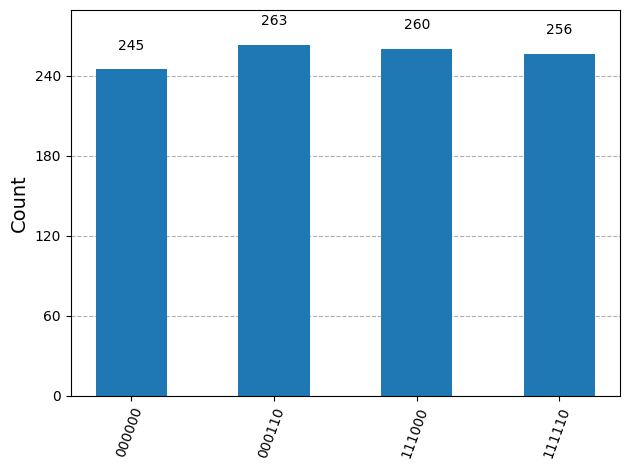

In [8]:
counts = AerSimulator().run(qc, shots=1024).result().get_counts()
print(counts)
plot_histogram(counts)

the bit order is frm right to left where the measurement from the first qubit $q_0$ is the position on the far left and continues towards the right. by this convention we can see the first output `111000` combines both the first and second registers where the first register is `000` and the second register is `111`.

In [9]:
sub_results = {}
for count in counts.keys():
    rev = count[::-1]
    intp_count = count[inp_qubits:]
    count_val = counts[count]
    sub_results.update({
        intp_count: sub_results.get(intp_count, 0)+ count_val
    })
print(sub_results)

{'000': 505, '110': 519}


as we have string values are reversed so `110` is actually `011` our secret string of course if we only had `000` as the result this would mean that $f$ would be a one to one function
we get s == '011' and '000' so it is two to one function